In [74]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils import data

from collections import Counter
import unicodedata

import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
torch.__version__, np.__version__, pd.__version__

('2.0.1+cu117', '1.21.5', '1.2.4')

In [76]:
focue_CPU = False
#focue_CPU = True

def get_device():
    curr_dev = torch.device("cpu")
    if focue_CPU == True:
        curr_dev = torch.device("cpu")
    else:
        curr_dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return curr_dev

curr_device = get_device()
print("current device : ", curr_device)
#currr_device = torch.device("cpu")

current device :  cuda:0


In [77]:
def corr2d(X,K):
    '''计算相互关运算'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0]-h+1, X.shape[1]- w +1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w]*K).sum()
    return Y

In [78]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
X, K

(tensor([[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]),
 tensor([[0., 1.],
         [2., 3.]]))

In [79]:
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [80]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super.__init__()
        self.weight = nn.parameter(torch.rand(kernel_size))
        self.bias = nn.parameter(torch.zeros(1))

    def forward(self, X):
        return corr2d(X, self.weight) + self.bias

In [81]:
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [82]:
K = torch.tensor([[1.0,-1.0]])
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [83]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(20):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 2.561
epoch 4, loss 0.473
epoch 6, loss 0.097
epoch 8, loss 0.024
epoch 10, loss 0.007
epoch 12, loss 0.002
epoch 14, loss 0.001
epoch 16, loss 0.000
epoch 18, loss 0.000
epoch 20, loss 0.000


In [84]:
conv2d.weight.data

tensor([[[[ 0.9991, -1.0007]]]])

In [93]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5, padding=2, stride=1), nn.Sigmoid(), 
    nn.AvgPool2d(kernel_size=2, stride= 2),
    nn.Conv2d(6,16,kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [94]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 18])


In [95]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

label: tensor(1)


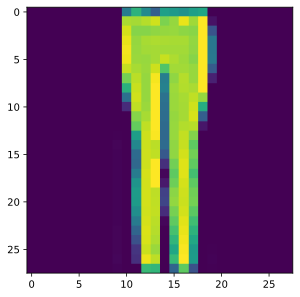

In [96]:

image, label = next(iter(train_iter))  	# 获得一个小批量
plt.imshow(image[0].squeeze())  		# 显示批量中的图片[0]
print('label:', label[0])  				# 显示标签


In [97]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale,  num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.inshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [98]:
ttt = iter(train_iter)

256

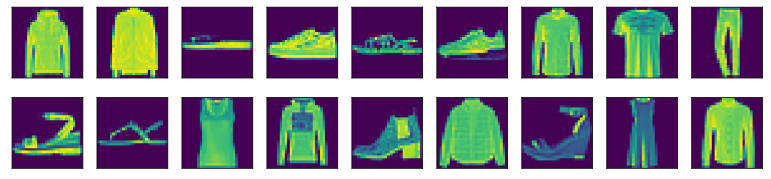

In [99]:
###X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
X, y = next(ttt)
show_images(X.reshape(256,28,28), 2, 9)
len(X)

In [100]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [101]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) 
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.470, train acc 0.824, test acc 0.809
76252.9 examples/sec on cuda:0


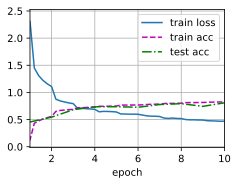

In [102]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())